In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
from os import pardir, mkdir
from scipy import interpolate
from matplotlib.ticker import LinearLocator

In [2]:
root_data_dir = abspath(join(pardir, "Data"))
comp_dir = join(root_data_dir, "Completeness")

In [3]:
name = "Effective-Volume"
data_dir = join(root_data_dir, name)
try:
    mkdir(data_dir)
    print(f"Creating {name} dir in Data dir")
except FileExistsError:
    print("Directory already exist. Good to go!")

Directory already exist. Good to go!


In [4]:
comp_raw = vaex.open(join(comp_dir, "comp-AG-extended-per-jk.hdf5"))
comp_raw

#,comp_per_jk,JK,DM
0,0.0,-0.10790019035339356,0.0
1,0.0,-0.10790019035339356,0.07035175879396985
2,0.0,-0.10790019035339356,0.1407035175879397
3,0.0,-0.10790019035339356,0.21105527638190955
4,0.0,-0.10790019035339356,0.2814070351758794
...,...,...,...
"20,195",0.0,0.43089966773986815,13.71859296482412
"20,196",0.0,0.43089966773986815,13.78894472361809
"20,197",0.0,0.43089966773986815,13.859296482412061
"20,198",0.0,0.43089966773986815,13.92964824120603


In [5]:
DM = comp_raw.DM.to_numpy()
DM = np.unique(DM)

JK = comp_raw.JK.to_numpy()
JK = np.unique(JK)

comp = np.zeros((len(DM), len(JK)))
for i in range(len(DM)):
    comp[i] = comp_raw[comp_raw.DM == DM[i]].comp_per_jk.to_numpy()
comp

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.95280497e-08, 4.29668020e-08, 2.81024656e-08],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

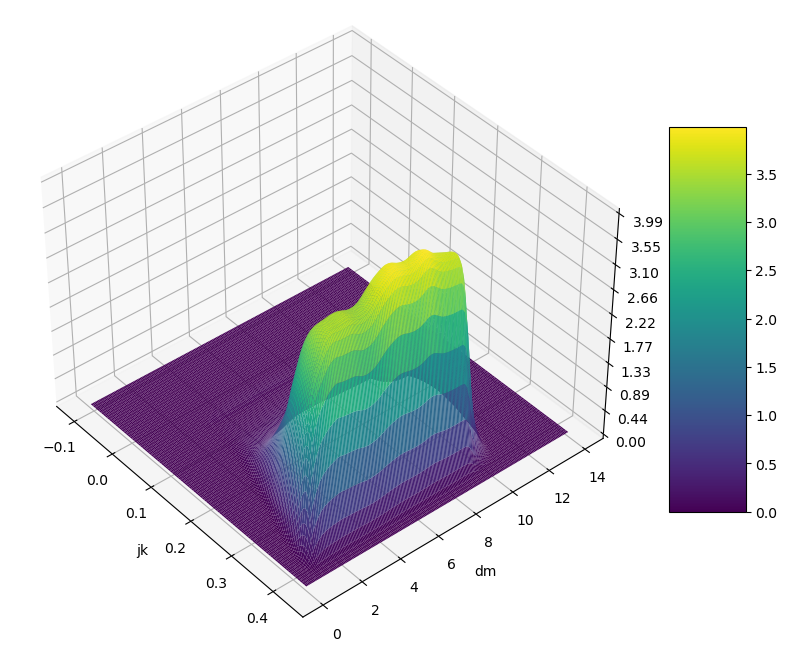

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
jk, dm = np.meshgrid(JK,DM) 
surf = ax.plot_surface(jk, dm, comp, cmap='viridis', rstride=1, cstride=1,
                 edgecolor='none')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(elev=40., azim=-40)
ax.set_xlabel("jk")
ax.set_ylabel("dm")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Text(0, 0.5, 'JK')

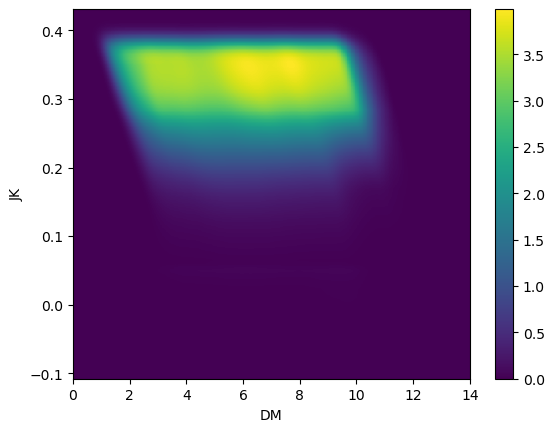

In [7]:
plt.imshow(comp.T, origin="lower", extent=[DM.min(), DM.max(), JK.min(), JK.max()], aspect="auto")
plt.colorbar()
plt.xlabel("DM")
plt.ylabel("JK")

In [8]:
comp_interp_ = interpolate.interp2d(jk, dm, comp, kind='linear', fill_value=0)
# return 0 if the result is negative
comp_interp = lambda jk, dm: np.maximum(comp_interp_(jk, dm), 0)

/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=110,190 m=20200 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


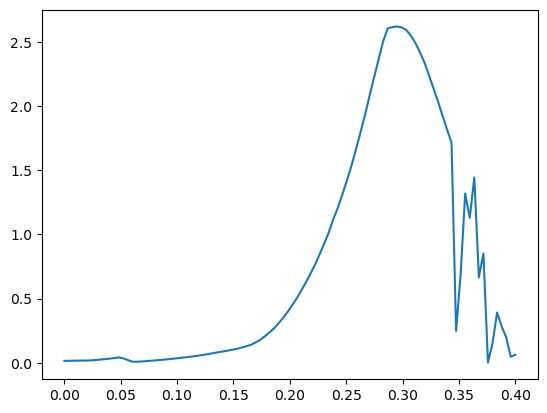

In [9]:
jjk = np.linspace(0, 0.4, 100)
plt.plot(jjk, comp_interp(jjk, 10))

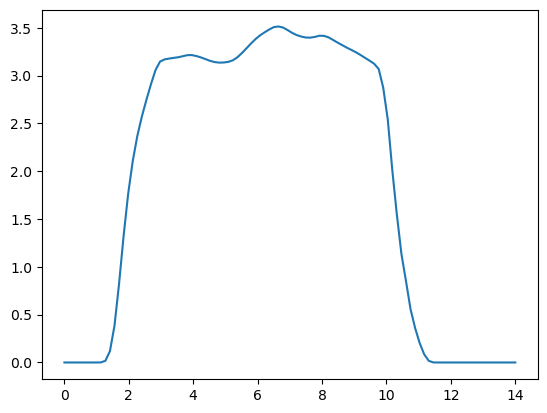

In [11]:
ddm = np.linspace(0, 14, 100)
plt.plot(ddm, comp_interp(0.3, ddm))

In [12]:
Z = 200
R = 150

In [13]:
# divide space into small tube with rings
ez = np.linspace(-Z, Z, 100) #edges
er = np.linspace(0, R, 100)
ephi = np.linspace(0, 2*np.pi, 100)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2
phi = (ephi[:-1]+ephi[1:])/2

In [14]:
dJK = JK[1]-JK[0]

In [15]:
vol = np.empty((len(JK), len(z), len(r), len(phi)))
real_vol = np.empty((len(z), len(r), len(phi)))
dz = ez[1]-ez[0]
dphi = ephi[1]-ephi[0]

In [16]:
for i, zz in enumerate(z):
    for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
        v = dphi/2*(r_out**2-r_in**2)*dz
        distance =np.sqrt(rr**2+zz**2)
        dm = 5*np.log10(distance)-5
        for k, pphi in enumerate(phi):
            for h, jk in enumerate(JK):
                c = comp_interp(jk, dm)
                vol[h, i, j, k] = v*c
            real_vol[i, j, k] = v
        print(j, end=" ")
    print("=============")
    print(i)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 =============
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 =============
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 =============
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33

In [17]:
vz = np.array([np.sum(vol[k], axis=(1,2)) for k in range(len(JK))])
real_vz = np.sum(real_vol, axis=(1,2))
vz

array([[8.59737358e-02, 8.61399755e-02, 8.62902788e-02, ...,
        8.62902788e-02, 8.61399755e-02, 8.59737358e-02],
       [5.24589626e-01, 5.25000766e-01, 5.25418755e-01, ...,
        5.25418755e-01, 5.25000766e-01, 5.24589626e-01],
       [2.59471086e+00, 2.59447893e+00, 2.59439166e+00, ...,
        2.59439166e+00, 2.59447893e+00, 2.59471086e+00],
       ...,
       [1.95886923e+03, 1.95385661e+03, 1.94907306e+03, ...,
        1.94907306e+03, 1.95385661e+03, 1.95886923e+03],
       [4.13917278e+02, 4.12782690e+02, 4.11674635e+02, ...,
        4.11674635e+02, 4.12782690e+02, 4.13917278e+02],
       [7.19270287e+01, 7.17222112e+01, 7.15173733e+01, ...,
        7.15173733e+01, 7.17222112e+01, 7.19270287e+01]])

In [18]:
compz = np.array([vz[i]/real_vz for i in range(len(JK))])
compz

array([[3.01029191e-07, 3.01611264e-07, 3.02137537e-07, ...,
        3.02137537e-07, 3.01611264e-07, 3.01029191e-07],
       [1.83680270e-06, 1.83824228e-06, 1.83970582e-06, ...,
        1.83970582e-06, 1.83824228e-06, 1.83680270e-06],
       [9.08514330e-06, 9.08433120e-06, 9.08402567e-06, ...,
        9.08402567e-06, 9.08433120e-06, 9.08514330e-06],
       ...,
       [6.85880186e-03, 6.84125063e-03, 6.82450147e-03, ...,
        6.82450147e-03, 6.84125063e-03, 6.85880186e-03],
       [1.44929358e-03, 1.44532092e-03, 1.44144117e-03, ...,
        1.44144117e-03, 1.44532092e-03, 1.44929358e-03],
       [2.51845927e-04, 2.51128778e-04, 2.50411557e-04, ...,
        2.50411557e-04, 2.51128778e-04, 2.51845927e-04]])

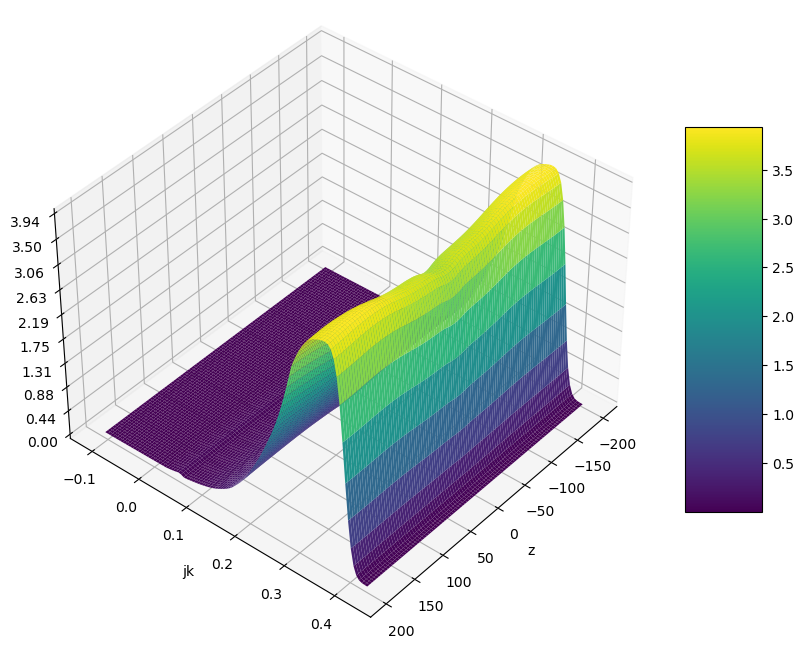

In [19]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
zz, jk = np.meshgrid(z, JK) 
surf = ax.plot_surface(zz, jk, compz, cmap='viridis', rstride=1, cstride=1,
                 edgecolor='none')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(elev=40., azim=40)
ax.set_xlabel("z")
ax.set_ylabel("jk")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

(0.0, 1.0)

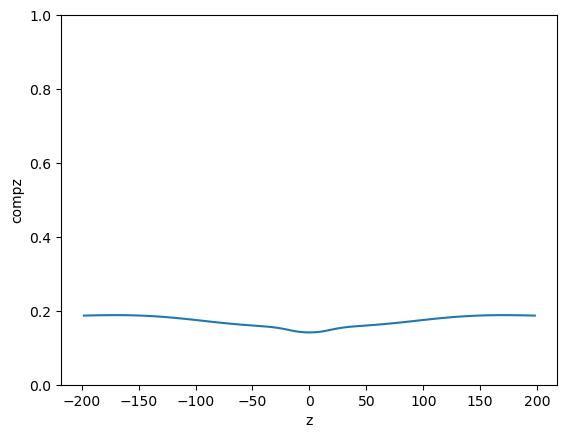

In [25]:
compzz = np.sum(compz, axis=0)*dJK
plt.plot(z, compzz**3)
plt.xlabel("z")
plt.ylabel("compz")
plt.ylim(0,1)

In [23]:
df_comp = []
N = compz.shape[1]
for i, jks_ in enumerate(JK):
    df_new = vaex.from_dict({
        "comp_per_jk": compz[i], 
        "JK": np.repeat(jks_, N),
        "z": z, 
      })
    if len(df_comp) == 0:
        df_comp = df_new
    else:
        df_comp = df_comp.concat(df_new)
df_comp

#,comp_per_jk,JK,z
0,3.0102919055569836e-07,-0.10790019035339356,-197.97979797979798
1,3.01611263834806e-07,-0.10790019035339356,-193.93939393939394
2,3.0213753702660635e-07,-0.10790019035339356,-189.8989898989899
3,3.024371612709229e-07,-0.10790019035339356,-185.85858585858585
4,3.0243204186622707e-07,-0.10790019035339356,-181.8181818181818
...,...,...,...
"9,994",0.00024904545005618035,0.43089966773986815,181.81818181818187
"9,995",0.00024971426288818334,0.43089966773986815,185.85858585858588
"9,996",0.00025041155651743687,0.43089966773986815,189.8989898989899
"9,997",0.0002511287778409573,0.43089966773986815,193.93939393939394


In [24]:
df_comp.export(join(data_dir, "comp-AG-extended-per-jk.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.30s =  0.0m =  0.0h
 

# models

/tmp/ipykernel_16748/3587848385.py:6: RuntimeWarning: overflow encountered in exp
  comp = A/(1+np.exp(((dm-dm0)/delta)**14))


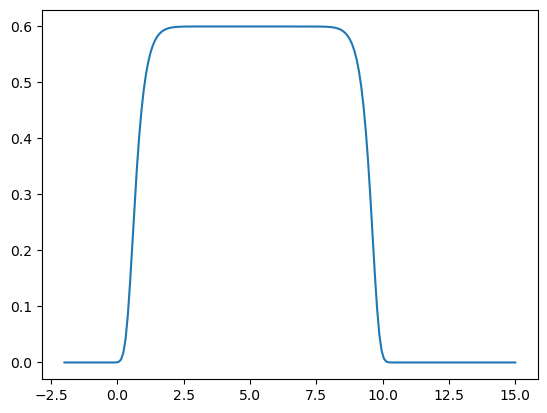

In [14]:
dm = np.linspace(-2, 15, 200)
# dm0 = 7.1
dm0=5.1
delta = 4.4
A = 1.2
comp = A/(1+np.exp(((dm-dm0)/delta)**14))
plt.plot(dm, comp)

(0.0, 300.0)

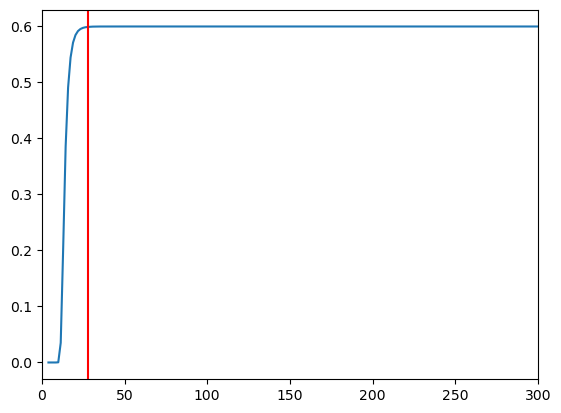

In [15]:
distance = np.power(10, (dm+5)/5)
compD = interpolate.interp1d(distance, comp, kind='cubic', fill_value="extrapolate")

dist = np.linspace(np.min(distance), 300, 200)

plt.plot(dist, compD(dist))
plt.axvline(28, color="red")
plt.xlim(0, 300)

In [ ]:
Z = 200
R = 150

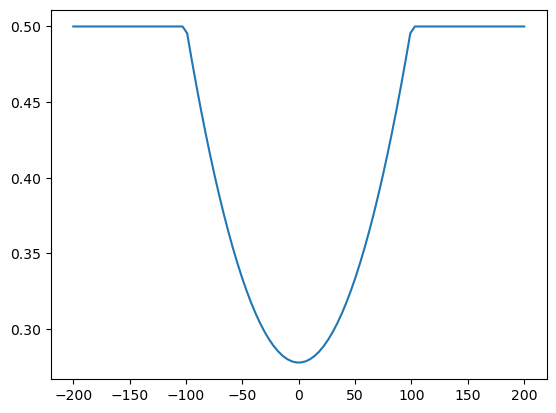

In [7]:
R = 150
r = 100
Z = 200
z = np.linspace(-Z, Z, 100)

comp = (1-np.maximum((r**2-z**2)/R**2, 0))*0.5

plt.plot(z, comp)


# tes

In [20]:
comp = vaex.open(join(comp_dir, "comp-A.hdf5"))
comp

#,comp,DM
0,0.0,0.0
1,0.0,0.07035175879396985
2,0.0,0.1407035175879397
3,0.0,0.21105527638190955
4,0.0,0.2814070351758794
...,...,...
195,0.0,13.71859296482412
196,0.0,13.78894472361809
197,0.0,13.859296482412061
198,0.0,13.92964824120603


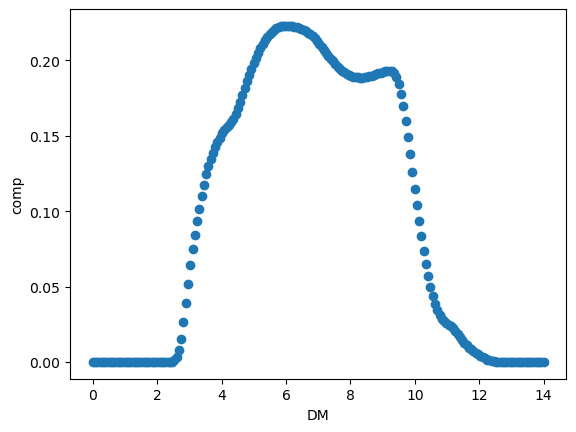

In [21]:
comp.viz.scatter("DM", "comp")

In [22]:
comp_interp_ = interpolate.interp1d(comp.DM.to_numpy(), comp.comp.to_numpy(), kind='cubic', fill_value="extrapolate")
comp_interp = lambda dm: np.maximum(comp_interp_(dm), 0)

In [23]:
Z = 200
R = 150

In [24]:
# divide space into small tube with rings
ez = np.linspace(-Z, Z, 100) #edges
er = np.linspace(0, R, 100)
ephi = np.linspace(0, 2*np.pi, 100)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2
phi = (ephi[:-1]+ephi[1:])/2

In [25]:
vol = np.empty((1, len(z), len(r), len(phi)))
real_vol = np.empty((len(z), len(r), len(phi)))
dz = ez[1]-ez[0]
dphi = ephi[1]-ephi[0]

In [26]:
for i, zz in enumerate(z):
    for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
        v = dphi/2*(r_out**2-r_in**2)*dz
        distance =np.sqrt(rr**2+zz**2)
        dm = 5*np.log10(distance)-5
        for k, pphi in enumerate(phi):
            for h in range(1):
                c = comp_interp(dm)
                vol[h, i, j, k] = v*c
            real_vol[i, j, k] = v
    #     print(j, end=" ")
    # print("=============")
    print(i, end=" ")


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

In [28]:
vz = np.array([np.sum(vol[k], axis=(1,2)) for k in range(1)])
real_vz = np.sum(real_vol, axis=(1,2))
vz

array([[61992.3975174 , 62149.73222513, 62297.78588854, 62436.81620305,
        62566.74884755, 62687.26116999, 62798.04518299, 62899.10199717,
        62990.89262977, 63074.30423776, 63150.25745392, 63219.13661179,
        63280.33793277, 63332.17613792, 63372.23455518, 63397.91235922,
        63406.74897074, 63396.44299676, 63364.70236629, 63309.11001856,
        63227.09616116, 63115.91455275, 62972.68003387, 62794.54512404,
        62579.12797395, 62324.80656365, 62030.65002306, 61696.14844955,
        61321.09097638, 60906.47841255, 60458.04864501, 59989.81081295,
        59519.46048262, 59055.27423636, 58591.19164856, 58119.19584841,
        57633.8028485 , 57121.78881644, 56560.77270605, 55941.52535804,
        55244.03830406, 54494.48360023, 53802.61515194, 53202.39125446,
        52694.54089228, 52279.0588252 , 51955.92191846, 51725.11000351,
        51586.63904702, 51540.47706446, 51586.63904702, 51725.11000351,
        51955.92191846, 52279.0588252 , 52694.54089228, 53202.39

In [31]:
compz = np.array([vz[i]/real_vz for i in range(1)])
compz

array([[0.21706072, 0.21761162, 0.21813001, 0.21861681, 0.21907176,
        0.21949372, 0.21988162, 0.22023547, 0.22055686, 0.22084892,
        0.22111486, 0.22135604, 0.22157033, 0.22175184, 0.2218921 ,
        0.221982  , 0.22201295, 0.22197686, 0.22186572, 0.22167107,
        0.22138391, 0.22099462, 0.22049309, 0.21986937, 0.21911511,
        0.21822462, 0.21719466, 0.21602343, 0.2147102 , 0.21325848,
        0.21168834, 0.21004885, 0.20840196, 0.20677665, 0.20515171,
        0.20349906, 0.2017995 , 0.20000673, 0.19804238, 0.19587415,
        0.19343196, 0.19080746, 0.18838495, 0.18628332, 0.18450513,
        0.18305035, 0.18191892, 0.18111075, 0.18062591, 0.18046428,
        0.18062591, 0.18111075, 0.18191892, 0.18305035, 0.18450513,
        0.18628332, 0.18838495, 0.19080746, 0.19343196, 0.19587415,
        0.19804238, 0.20000673, 0.2017995 , 0.20349906, 0.20515171,
        0.20677665, 0.20840196, 0.21004885, 0.21168834, 0.21325848,
        0.2147102 , 0.21602343, 0.21719466, 0.21

(0.0, 0.3)

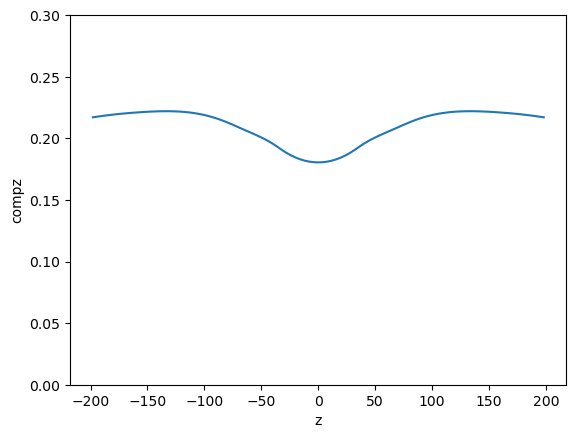

In [34]:
compzz = np.sum(compz, axis=0)
plt.plot(z, compzz)
plt.xlabel("z")
plt.ylabel("compz")
plt.ylim(0,0.3)

In [35]:
df_new = vaex.from_arrays(z=z, compz=compzz)
df_new

#,z,compz
0,-197.97979797979798,0.21706072297827017
1,-193.93939393939394,0.21761161610026283
2,-189.8989898989899,0.21813001249251016
3,-185.85858585858585,0.21861681445196965
4,-181.8181818181818,0.2190717617500962
...,...,...
94,181.81818181818187,0.21907176175009618
95,185.85858585858588,0.21861681445196965
96,189.8989898989899,0.21813001249251016
97,193.93939393939394,0.21761161610026283


In [37]:
df_new.export(join(data_dir, "comp-A.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.06s =  0.0m =  0.0h
 